# Laboratorio nº3 de Experimental

In [4]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from scipy.stats import t as tStudent
from sigfig import round
import csv
import os.path
from scipy import stats

In [31]:
Tanda_1 = np.genfromtxt("./Datos Tanda/Tanda 1.csv", names=["Sensor_Caliente", "Sensor_Frio"], dtype=float,delimiter=',')

# Experimentos 

### Funciones de gráfico y ajuste

In [32]:
## graficador es una función graficadora de datos de Temperatura versus tiempo y de las curvas ajustadas (Ver función Fitteador)
# 
# @params Tem_C Es la lista con valores de temperatura caliente
# @params Tem_F Es la lista con valores de temperatura fria
# @params X es la lista con los valores de la variable independiente (tiempo)
# @params TipoDato es una variable dicotomica para seleccionar entre graficar datos o regresiones
# @params Lims Es una lista que especifica el espaciado de la grilla del gráfico 
# @params k es un valor que indica cada cuantos segundos se toma el dato en Tem_C y Tem_F
# @params ax son los ejes donde se grafica de la libreria matplotlib
# @params fig es la figura donde se grafica de la libreria %matplotlib
# 
# @return None
def graficador(Tem_C , Tem_F , X , TipoDato , Lims , k , ax , fig):
    if TipoDato == 'Curva':
        EstiloCaliente = dict(color = 'm' , linestyle='-' , linewidth=1.6 , label = 'Recipiente Caliente (Curva ajustada)')
        EstiloFrio     = dict(color = 'k' , linestyle='-' , linewidth=1.6 , label = 'Recipiente Frio (Curva ajustada)')
    elif TipoDato == 'Datos':
        EstiloCaliente = dict(color = 'r', marker = 'o' , markersize=1 , linewidth=0, label = 'Recipiente Caliente')
        EstiloFrio     = dict(color = 'b', marker = 'o' , markersize=1 , linewidth=0, label = 'Recipiente Frío')
        
    
    ax.set_xlim(0, X[-1])
    ax.set_ylim(Tem_F[0],Tem_C[0])  
    
    ax.xaxis.set_major_locator(MultipleLocator( Lims[0])) # Distancia entre marcas verticales mayores de la grilla, con valor en eje X
    ax.yaxis.set_major_locator(MultipleLocator( Lims[2])) 
    ax.xaxis.set_minor_locator(AutoMinorLocator(Lims[1])) # Cantidad de marcas verticales menores entre las mayores, sin valor en eje X 
    ax.yaxis.set_minor_locator(AutoMinorLocator(Lims[3]))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    
    ax.plot(X,Tem_C,**EstiloCaliente)
    ax.plot(X,Tem_F,**EstiloFrio)
    
    
    if k==1:
        plt.xlabel('Tiempo [s]')
    elif k>1:
        plt.xlabel(f'Tiempo cada {k} seg.')
    plt.ylabel('Temperatura [ºC]')
    plt.title('Datos experimentales y ajustes de curvas')

In [7]:
## Fitteador es una función ajustadora de los datos de Temperatura haciendo uso de un sistema de ecuaciones diferenciales acopladas, resueltas
## por odeint de la libreria scipy.integrate y ajustadas por curve_fit de la libreria scipy.optimize. También grafica los datos y las 
## regresiones haciendo uso de la función graficador, por último presenta los parametros ajustados en pantalla con sus respectivos
## errores.
# 
# @params Tem_C Es la lista con valores de temperatura caliente
# @params Tem_F Es la lista con valores de temperatura fria
# @params Lims Es una lista que especifica el espaciado de la grilla del gráfico (Ver función: graficador)
# @params k es un valor que indica cada cuantos segundos se toma el dato en Tem_C y Tem_F
# 
# @return popt son los valores ajustados para los datos Tem_C y Tem_F
# @return pcov es la matríz de covarianza de los parámetros ajustados
# @return N es la cantidad de datos de Tem_C y Tem_F
def Fitteador(Tem_C , Tem_F , Lims , k):
    Tem_C , Tem_F = Tem_C[::k] , Tem_F[::k]
    N = len(Tem_C)
    t_data = np.linspace(1,N*k,N)  
    T0     = [Tem_C[0], Tem_F[0]]  
    
    def f(T, t, k1, k2, k12):
        TC, TF = T
        dTCdt = -k12 * TF + (k1 + k12) * TC - k1 * 19.8 # La temperatura ambiente medida fue de 19.8 ºC
        dTFdt = -k12 * TC + (k2 + k12) * TF - k2 * 19.8
        return [-dTCdt, -dTFdt]
    
    def curve(t, k1, k2, k12):      
        sol = odeint(f , T0 , t , args=(k1, k2, k12))
        return sol.T.ravel()

    p0 = [0.0027 , 0.0095 , 0.007 ]

    popt, pcov = curve_fit(curve , t_data , np.hstack((Tem_C, Tem_F)) , p0=p0)
    if Lims == 0:
        pass
    else:    
        
        Regresion = curve(t_data, *popt)
        fig, ax = plt.subplots(figsize=(10, 8))
        
        graficador(Tem_C,Tem_F,t_data,'Datos',Lims,k,ax,fig)
        graficador(Regresion[:N],Regresion[N:],t_data,'Curva',Lims,k,ax,fig)
        fig.legend(loc=9,bbox_to_anchor=(0.737, 0.88))
        fig.savefig('DatosYRegresion.jpg',dpi=120)
        gamma = 0.01
        t_n  = tStudent.ppf(1-gamma/2, len(t_data)-1)
    
        print(f'''El valor de k1 es {round(popt[0],np.sqrt(pcov[0][0])*t_n)}
El valor de k2 es {                  round(popt[1],np.sqrt(pcov[1][1])*t_n)}
El valor de k12 es {                 round(popt[2],np.sqrt(pcov[2][2])*t_n)}
\n''')
    return [popt, pcov,N]

### Trabajo de los datos

#### Sistema de ecuaciones diferenciales acopladas

$\dot{T_1}+k_1*(T_1-T_A)+k_{12}*(T_1-T_2)=0$

$\dot{T_2}+k_2*(T_2-T_A)+k_{12}*(T_2-T_1)=0$

Realizando un cambio de variables del tipo $\tau_i=T_i-T_A$ el sistema de EDOs queda homogeneo: 

$\dot{\tau_1}+\tau_1*(k_1+k_{12})-k_{12}*\tau_2=0$

$\dot{\tau_2}+\tau_2*(k_2+k_{12})-k_{12}*\tau_1=0$

Llevado a una formulación matricial queda:

$\begin{align}
    \dot{\begin{bmatrix}
           \tau_{1} \\
           \tau_{2} 
         \end{bmatrix}}
  =    \begin{bmatrix}
           k_1+k_{12} && -k_{12}\\
           -k_{12}    && k_2+k_{12} 
    \end{bmatrix}
  \cdot      \begin{bmatrix}
           \tau_{1} \\
           \tau_{2}
    \end{bmatrix}
  \end{align}$

#### Tanda de datos experimentales

El valor de k1 es 0.00107 ± 0.00002
El valor de k2 es 0.00044 ± 0.00005
El valor de k12 es 0.00360 ± 0.00004




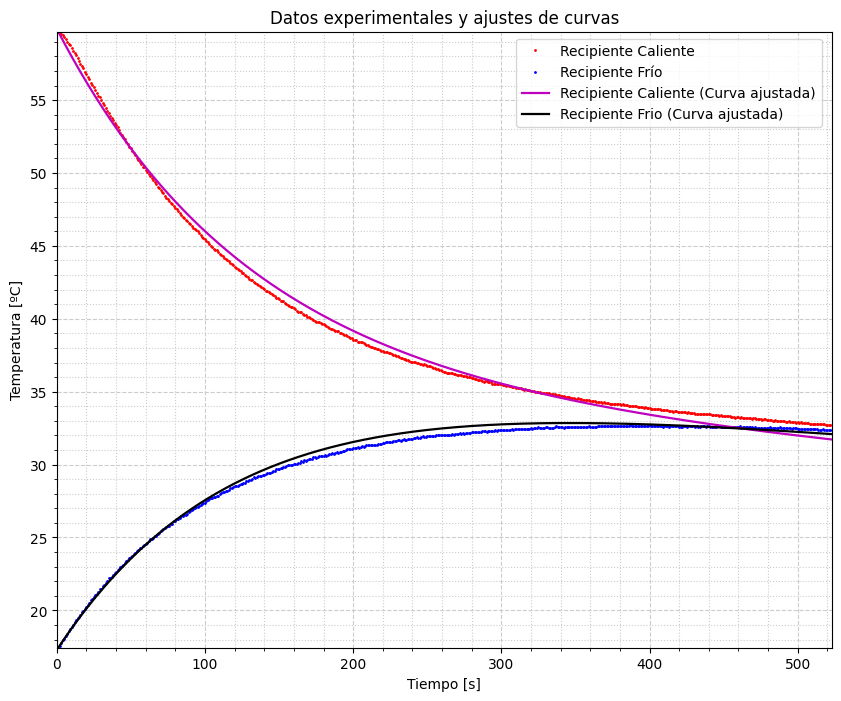

In [33]:
(popt1 , pcov1 , N1) = Fitteador(Tanda_1['Sensor_Caliente'] , Tanda_1['Sensor_Frio'] , [100,5,5,5] , 1)

## Lector de datos con formato arduino y traductor a .csv

In [22]:
## Cervantes es una función usada para leer los datos obtenidos del pertos serial arduino y pegados en un archivo del cual se van a leer,
## una vez ya obteniidos estos datos, se escriben en un archivo csv diferenciando los sensores con las etiquetas 'Sensor_Caliente' y 'Sensor_Frio'  
# 
# @params None
# @return None
def Cervantes():
    archivo = input('Introduzca el nombre del archivo con los datos: ')  
    nombre_csv = input('Introduzca el número de tanda: ')
    nombre_csv = './Datos Tanda/Tanda ' + nombre_csv + '.csv' # Todos los datos obtenidos del sensor se guardaran en la carpeta Datos Tanda 
    sensor_1 = []
    sensor_2 = []
    with open(archivo, 'r') as file2:
        for line in file2:
            partes = line.strip().split(': ') # Division de (Sensor 1 : xx.xxC) en (Sensor 1 : )(xx.xxC) y guardar ambos en variable partes
            
            if len(partes) == 2: # Asegurarse de no agarrar una linea en blanco
                nombre_sensor = partes[0]
                valor_temp = partes[1]
                
                if nombre_sensor == 'Sensor 1 ':
                    sensor_1.append(float(valor_temp[:-1])) # [:-1] pide todos los valores de la lista (el :) exepto el útimo (el -1) donde el útimo es C 
                    
                elif nombre_sensor == 'Sensor 2 ':
                    sensor_2.append(float(valor_temp[:-1]))  
                    
    with open(nombre_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['#Sensor_Caliente', 'Sensor_Frio']) # etiquetas de las columnas
        
        if sensor_1[0]>sensor_2[0]:
            for sen1, sen2 in zip(sensor_1,sensor_2):
                writer.writerow([sen1, sen2])
        else:
            for sen1, sen2 in zip(sensor_1,sensor_2):
                writer.writerow([sen2, sen1])

    print("Los datos se han guardado correctamente en el archivo CSV:", nombre_csv)

In [ ]:
## escritorTanda es una funcion para escribir los resultados de la función Fitteador en un archivo .csv en la carpeta Resultados/Tandas
# 
# @params popt son los parámetros ajustados por curve_fit (Ver función Fitteador)
# @params pcov es la matriz de covarianza de los parámetros ajustados (Ver función Fitteador) 
# @params N es la cantidad de datos usadosen el ajuste de los datos
# 
# @return None
def escritorTanda(popt , pcov , N):
    k1, k2, k12 = popt
    S1, S2, S12 = np.diag(pcov)
    
    # Toda esta parte es para la elección del nombre del archivo de salida
    Y_N2 = 'N'
    n = input('Introduzca el número de tanda: ')
    m = 0
    Dir = f'./Resultados/Tandas/Tanda_{n}.csv'
    if os.path.isfile(Dir):
        Y_N = input('El archivo ya existe, desea sobreescribirlo? [Y/N] ').upper() 
        
        if Y_N == 'N':
            while os.path.isfile(Dir) and Y_N2 == 'N':
                Y_N2 = input(f'El archivo {Dir} \nya existe, desea sobreescribirlo? [Y/N] ').upper()
                Dir = f'./Resultados/Tandas/Tanda_{n}_{m}.csv' 
                m+=1
        else:
            pass
    # A partir de aqui empieza la escritura del archivo .csv
    with open(Dir, mode = 'w', newline = '') as file:
        
        writer = csv.writer(file)
        writer.writerows([['#k_1','k_2','k_12','N'], # 1ra fila etiquetas 
                          [  k1  ,  k2 ,  k12 , N ], # 2da fila valores
                          [  S1  ,  S2 ,  S12 ,  0]])# 3ra fila varianzas
    print("Los datos se han guardado correctamente en el archivo CSV:", Dir)

In [26]:
Cervantes()

Introduzca el nombre del archivo con los datos:  Datos tanda 1
Introduzca el número de tanda:  1


Los datos se han guardado correctamente en el archivo CSV: ./Datos Tanda/Tanda 1.csv


In [ ]:
escritorTanda(popt1,pcov1,N1)

# Monte Carlo


### Funciones

In [34]:
## generadorMonteCarlo es una función que usa el método de Monte Carlo para generar datos aleatorios a partir de los que fueron registrados en la variable 
## Tanda para luego ajustar sus parámetros de la ecuación diferencial (Ver función Fitteador) y almacenarlos en la variable Resultados. Para este método
## se usa el paquete numpy.random para generar los números aleatorios y las semillas que los reproducen.
# 
# @params Tanda es un diccionario con etiquetas 'Sensor_Caliente' y'Sensor_Frio' que devuelve los datos medidos por los sensores
# @params Repet es un número entero que indica la cantidad de repeticiones de generación de datos aleatorios
# @params Semillas puede ser un entero, haciendo que las semillas se generen aleatoriamente oo puede ser una lista con las semillas que se quiere 
# @params k es un valor que indica cada cuantos segundos se toma el dato en Tanda
# 
# @return Resultados es una matríz de tamaño Repet x 6 que contiene en sus columnas los parametros ajustados y sus correspondientes varianzas 
# @return Semillas es una lista con las semillas usadas durante el cálculo
# @return N es un entero con la cantidad de datos de la variable Tanda
# @return ErrT es un flotante con el error usadoen la generación de datos aleatorios
def generadorMonteCarlo(Tanda , Repet , Semillas , k):
    Tanda = Tanda[::k]
    ErrT = float(input('Introduzca el error en la temperatura para asignarselo al método Monte Carlo:\n')) 
    Data = np.hstack((Tanda['Sensor_Caliente'], Tanda['Sensor_Frio']))
    N = len(Tanda)
        
    Resultados = []
    if isinstance(Semillas,int) :
        Semillas = np.random.randint(0 , 1e6 , size = Repet) # Generador aleatorio de semillas en caso de no ingresar ninguna
    for i in range(0,Repet): 
        np.random.seed(Semillas[i])
        MCTanda = Data + np.random.randn(2*N) * ErrT # Valores aleatorios de distribución gausiana con ancho ErrT y media en cada dato
        Tem_C = MCTanda[:N]
        Tem_F = MCTanda[N:]
       
        popt, pcov = Fitteador(Tem_C , Tem_F , 0 , k)[:-1] # Ajuste de los valores aleatorios, se usa el [:-1] para obiar el N dado por Fitteador   
        Resultados.append(popt)
        Resultados.append(np.diag(pcov))
        
    Resultados = np.reshape(Resultados,(Repet,6)) # Armado de la matriz
    print(f'Las {Repet} simulaciones se calcularon con éxito\n')
    return Resultados , Semillas , N , ErrT 

In [39]:
## EscritorTandaMC es una funcion que permite escribir en un archivo .csv los datos oobtenidos al usar el método Monte Carlo 
## (Ver función GeneradorMonteCarlo) sobre los datos de la variable Tanda.   
# 
# @params Tanda es un diccionario con etiquetas 'Sensor_Caliente' y'Sensor_Frio' que devuelve los datos medidos por los sensores 
# @params Repet es un número entero que indica la cantidad de repeticiones de generación de datos aleatorios
# @params Semillas puede ser un entero, haciendo que las semillas se generen aleatoriamente oo puede ser una lista con las semillas que se quiere 
# @params k es un valor que indica cada cuantos segundos se toma el dato en Tanda
# 
# @return None
def escritorTandaMC(Tanda , Repet , Semillas , k):
    # Mismo funcionamiento de elección de nombre de archivo que la función escritorTanda
    Y_N2 = 'N'
    n = input('Introduzca el número de tanda: ')
    m = 0
    Dir = f'./Resultados/Monte Carlo/Tanda_{n}.csv'
    if os.path.isfile(Dir):
        Y_N = input('El archivo ya existe, desea sobreescribirlo? [Y/N] ').upper()
        
        if Y_N == 'N':
            Dir = f'./Resultados/Monte Carlo/Tanda_{n}_{m}.csv'
            while os.path.isfile(Dir) and Y_N2 == 'N':
                Y_N2 = input(f'El archivo {Dir} \nya existe, desea sobreescribirlo? [Y/N] ').upper()
                m+=1
        else:
            pass
    # Escitura del archivo .csv 
    with open(Dir, mode = 'w', newline = '') as file:
        Result, Semillas , _ , ErrT= generadorMonteCarlo(Tanda , Repet , Semillas , k)
        writer = csv.writer(file)
        # Escritura de etiquetas y de la primera linea con los valores de ErrT y N
        writer.writerows([['#k_1'      ,'k_2'        ,'k_12'       ,'SigmaSquared_k1','SigmaSquared_k2','SigmaSquared_k12','Semillas'   ,'Error_MC','Datos'],
                          [Result[0,0] , Result[0,1] , Result[0,2] , Result[0,3]     , Result[0,4]     , Result[0,5]      , Semillas[0] , ErrT     , N]])
        for i in range(1,Repet): 
            # Escribe en cada linea del archivo .csv los parametros de la repetición (i), las varianzas , la semilla usada, pero, sin el valor de ErrT ni N 
            writer.writerow([Result[i,0] , Result[i,1] , Result[i,2] , Result[i,3] , Result[i,4] , Result[i,5] , Semillas[i] , 'Nada','Nada'])
    print("Los datos se han guardado correctamente en el archivo CSV:", Dir)

## Resultados

Introduzca el error en la temperatura para asignarselo al método Monte Carlo:
 0.5


Las 2000 simulaciones se calcularon con éxito



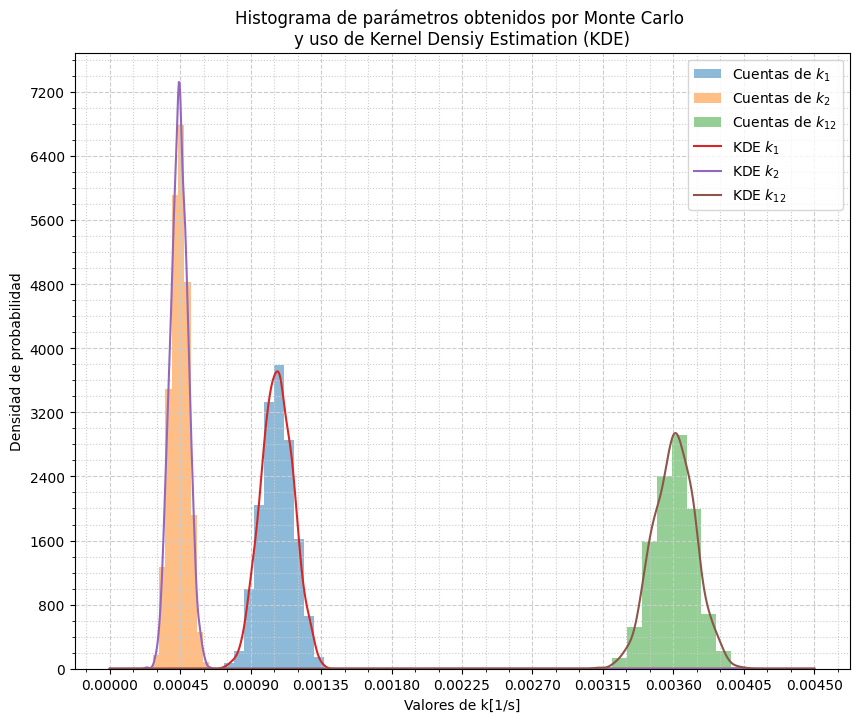


El valor de k_1  es 0.0011 ± 0.0001
El valor de k_2  es 0.00044 ± 0.00006
El valor de k_12 es 0.0036 ± 0.0001


In [35]:
## Esta sección está para aplicar el método Monte Carlo a los datos de la Tanda_1, ajustar los parámetros y con los datos obtenidos
## graficar sus histogramas, calcular sus promedios y respectivos errores 

Resultados , semillas , N , ErrT = generadorMonteCarlo(Tanda_1,2000,1,1) #Método Monte Carlo

fig, ax = plt.subplots(figsize=(10, 8))
# HISTOGRAMAS ############################################################
kwargs = dict(alpha=0.5 , density=True)
plt.hist(Resultados[:,0] , **kwargs , label = r'Cuentas de $k_1$' )
plt.hist(Resultados[:,1] , **kwargs , label = r'Cuentas de $k_2$' )
plt.hist(Resultados[:,2] , **kwargs , label = r'Cuentas de $k_{12}$')
# KDE's ##################################################################
kde1 = stats.gaussian_kde(Resultados[:,0])
kde2 = stats.gaussian_kde(Resultados[:,1])
kde12 = stats.gaussian_kde(Resultados[:,2])
# GRAFICAR ###############################################################
xx = np.linspace(0, 0.0045, 1000)
ax.plot(xx, kde1(xx) , label = r'KDE $k_1$ ')
ax.plot(xx, kde2(xx) , label = r'KDE $k_2$ ')
ax.plot(xx, kde12(xx), label = r'KDE $k_{12}$')

ax.xaxis.set_major_locator(MultipleLocator(0.00045)) # Distancia entre marcas verticales mayores de la grilla, con valor en eje X
ax.yaxis.set_major_locator(MultipleLocator(800)) 
ax.xaxis.set_minor_locator(AutoMinorLocator(3)) # Cantidad de marcas verticales menores entre las mayores, sin valor en eje X 
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.legend()
plt.title('Histograma de parámetros obtenidos por Monte Carlo \ny uso de Kernel Densiy Estimation (KDE)')
plt.xlabel('Valores de k[1/s]')
plt.ylabel('Densidad de probabilidad')
plt.show()
fig.savefig('HistogramaTanda1.jpg',dpi=90)
# PROMEDIO Y DESVIACIÓN ESTANDAR #########################################
gamma = 0.01
t_n  = tStudent.ppf(1-gamma/2, N-1)

MediaK1  = np.mean(Resultados[:,0])
MediaK2  = np.mean(Resultados[:,1])
MediaK12 = np.mean(Resultados[:,2])
DesvK1  = np.std(Resultados[:,0])
DesvK2  = np.std(Resultados[:,1])
DesvK12 = np.std(Resultados[:,2])
print(f'''
El valor de k_1  es {round(MediaK1,DesvK1)}
El valor de k_2  es {round(MediaK2,DesvK2)}
El valor de k_12 es {round(MediaK12,DesvK12)}''')


### Escritura

In [41]:
escritorTandaMC(Tanda_1 , 2000 , semillas , 1)

Introduzca el número de tanda:  1
El archivo ya existe, desea sobreescribirlo? [Y/N]  n
El archivo ./Resultados/Monte Carlo/Tanda_1_0.csv 
ya existe, desea sobreescribirlo? [Y/N]  y
Introduzca el error en la temperatura para asignarselo al método Monte Carlo:
 0.5


Las 2000 simulaciones se calcularon con éxito

Los datos se han guardado correctamente en el archivo CSV: ./Resultados/Monte Carlo/Tanda_1_0.csv


### Lectura

In [ ]:
Datos_Monte_Carlo = np.genfromtxt("./Resultados/Monte Carlo/Tanda_1.csv", names=['k_1','k_2','k_12','SigmaSquared_k1','SigmaSquared_k2','SigmaSquared_k12','Semillas','Error_MC','Datos'], dtype=[float,float,float,float,float,float,int,float,int],delimiter=',',missing_values='Nada',filling_values=0)
Semillas_MC = Datos_Monte_Carlo['Semillas']